In [1]:
from rllab.algos.trpo import TRPO
from rllab.baselines.linear_feature_baseline import LinearFeatureBaseline
from rllab.envs.gym_env import GymEnv
from rllab.envs.normalized_env import normalize
from rllab.policies.gaussian_mlp_policy import GaussianMLPPolicy
from rllab.policies.constant_control_policy import ConstantControlPolicy
import rllab.misc.logger as logger
from rllab.sampler import parallel_sampler
from test import test_const_adv, test_rand_adv, test_learnt_adv, test_rand_step_adv, test_step_adv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import gym
import random
import pickle
import scipy
import argparse

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


### Load

In [2]:
#filepath = 'results/Swimmer/env-SwimmerAdv-v1_Exp1_Itr500_BS25000_Adv0.25_stp0.01_lam0.97_435321.p'
#filepath = 'results/Hopper/env-HopperAdv-v1_Exp1_Itr500_BS25000_Adv0.25_stp0.01_lam1.0_369983_320.p'
#filepath = 'results/Cheetah/env-HalfCheetahAdv-v1_Exp1_Itr500_BS25000_Adv0.25_stp0.02_lam0.95_95277.p'
#filepath = 'results/Walker/env-Walker2dAdv-v1_Exp1_Itr500_BS25000_Adv0.25_stp0.01_lam0.97_516354.p'

#f1 = 'results/StaticSwimmer/static_env-SwimmerAdv-v1_Exp1_Itr500_BS25000_Adv5.0_stp0.01_lam0.97_159280.p'
#f1 = 'results/StaticHopper/static_env-HopperAdv-v1_Exp1_Itr500_BS25000_Adv3.0_stp0.01_lam1.0_154574.p'
#f1 = 'results/StaticCheetah/static_env-HalfCheetahAdv-v1_Exp1_Itr500_BS25000_Adv7.0_stp0.02_lam0.95_337519.p'

#f2 = 'results/adv_env-SwimmerAdv-v1_Exp1_Itr500_BS25000_Adv5.0_stp0.01_lam0.97_335999.p'
#f2 = 'results/adv_env-HopperAdv-v1_Exp1_Itr500_BS25000_Adv3.0_stp0.01_lam1.0_294322.p'
f2 = 'results/adv_env-HalfCheetahAdv-v1_Exp1_Itr500_BS25000_Adv7.0_stp0.02_lam0.95_296182.p'

filtercheck = 1

In [3]:
savename_1 = f1 #filepath to results
if_filtering = bool(filtercheck) #0 for no filtering. 1 for filtering

res_D_1 = pickle.load(open(savename_1,'rb'))

const_test_rew_summary_1 = res_D_1['zero_test']
rand_test_rew_summary_1 = res_D_1['rand_test']
adv_test_rew_summary_1 = res_D_1['adv_test']

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
[2018-01-30 02:23:02,550] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [4]:
savename_2 = f2 #filepath to results
if_filtering = bool(filtercheck) #0 for no filtering. 1 for filtering

res_D_2 = pickle.load(open(savename_2,'rb'))

const_test_rew_summary_2 = res_D_2['zero_test']
rand_test_rew_summary_2 = res_D_2['rand_test']
adv_test_rew_summary_2 = res_D_2['adv_test']

### Graph

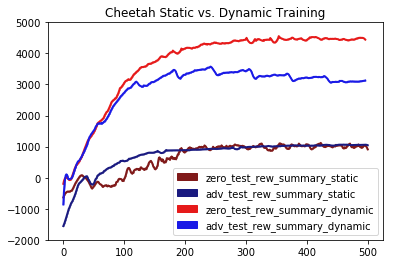

In [5]:
plot_tests = [const_test_rew_summary_1, adv_test_rew_summary_1, const_test_rew_summary_2, adv_test_rew_summary_2]
plot_names = ['zero_test_rew_summary_static', 'adv_test_rew_summary_static', 'zero_test_rew_summary_dynamic', 'adv_test_rew_summary_dynamic']
plot_colors = [(0.5,0.1,0.1), (0.1,0.1,0.5), (0.9,0.1,0.1), (0.1,0.1,0.9)]
all_patches = []
for i in range(len(plot_tests)):
    con_rew = np.array(plot_tests[i])
    mean_con = con_rew.mean(0)
    std_con = con_rew.std(0)
    if if_filtering==True:
        mean_window_size = 15
        mean_order = 3
        std_window_size = 45
        std_order = 2
        mean_con = scipy.signal.savgol_filter(mean_con, mean_window_size, mean_order)
        std_con = scipy.signal.savgol_filter(std_con, std_window_size, std_order)
    x = [i for i in range(len(mean_con))]
    plt.plot(x,mean_con,color=plot_colors[i], linewidth=2.0)
    plt.fill_between(x, mean_con-std_con, mean_con+std_con,color=plot_colors[i], alpha=0.5)
    all_patches.append(mpatches.Patch(color=plot_colors[i], label=plot_names[i]))

plt.legend(handles=all_patches)
axes = plt.gca()
axes.set_ylim([-2000,5000])
plt.title("Cheetah Static vs. Dynamic Training")
plt.show()

In [6]:
for i in range(len(plot_tests)):
    con_rew = np.array(plot_tests[i])
    mean_con = con_rew.mean(0)
    std_con = con_rew.std(0)
    if if_filtering==True:
        mean_window_size = 15
        mean_order = 3
        std_window_size = 45
        std_order = 2
        mean_con = scipy.signal.savgol_filter(mean_con, mean_window_size, mean_order)
        std_con = scipy.signal.savgol_filter(std_con, std_window_size, std_order)
    print(mean_con[len(mean_con)-1], std_con[len(std_con)-1])

912.500430785 0.0
1045.61669057 0.0
4445.61686328 0.0
3128.5761997 0.0


In [7]:
mean_cons = []
for i in range(len(plot_tests)):
    con_rew = np.array(plot_tests[i])
    mean_con = con_rew.mean(0)
    std_con = con_rew.std(0)
    if if_filtering==True:
        mean_window_size = 15
        mean_order = 3
        std_window_size = 45
        std_order = 2
        mean_con = scipy.signal.savgol_filter(mean_con, mean_window_size, mean_order)
        std_con = scipy.signal.savgol_filter(std_con, std_window_size, std_order)
    mean_cons.append(mean_con)
print( np.average(mean_cons[2]-mean_cons[0]) )
print( np.std(mean_cons[2]-mean_cons[0][:len(mean_cons[2])]) )
print( np.average(mean_cons[3]-mean_cons[1][:len(mean_cons[3])]) )
print( np.std(mean_cons[3]-mean_cons[1][:len(mean_cons[3])]) )

3012.70776429
831.33017826
2121.6945041
438.590197907


In [9]:
from scipy import stats

In [12]:
stats.ttest_rel(mean_cons[0][:len(mean_cons[2])], mean_cons[2])

Ttest_relResult(statistic=-80.70943345652563, pvalue=2.0466426482795633e-287)

In [13]:
stats.ttest_rel(mean_cons[1][:len(mean_cons[3])], mean_cons[3])

Ttest_relResult(statistic=-107.73697273795636, pvalue=0.0)